# Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data

In [3]:
data_path = 'data/match_4000710334517.csv'
data_df = pd.read_csv(data_path)
data_df.head()

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,sigma
0,4000710334517,0,269.749758,-29.186608,22819,4001061039486,-0.003813,-0.873028,-0.487656,0.03655
1,4000710334517,0,269.749758,-29.186608,44893,4001212780699,-0.003814,-0.873028,-0.487656,0.06405
2,4000710334517,0,269.749758,-29.186608,44893,4001212780710,-0.003812,-0.873028,-0.487656,0.03850
3,4000710334517,0,269.749758,-29.186608,44909,4001120525362,-0.003813,-0.873028,-0.487656,0.03395
4,4000710334517,0,269.749758,-29.186608,44923,4001152086466,-0.003813,-0.873028,-0.487656,0.01605


In [30]:
from collections import defaultdict

counts = defaultdict(int)
for row in data_df.itertuples():
    counts[(row.RA, row.Dec)] += 1

# Calculate center of all objects in Ra and Dec
centers_ra_decs = list(counts.keys())
num_counts = sum(counts.values())
center_ra = sum(c[0] * counts[c] for c in centers_ra_decs) / num_counts
center_dec = sum(c[1] * counts[c] for c in centers_ra_decs) / num_counts

# Convert to 2D coordinates

In [31]:
def tangent(ra: float, dec: float) -> tuple[np.ndarray, np.ndarray]:
    """Returns the tangent vectors pointing to west and north.

    Args:
        ra (float): right ascension in degrees
        dec (float): declination in degrees

    Returns:
        tuple[float,float]: west and north vectors
    """
    # Convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    
    # Get sin and cos of ra and dec
    sinRa = np.sin(ra)
    cosRa = np.cos(ra)
    sinDec = np.sin(dec)
    cosDec = np.cos(dec)
    
    # Get tangent vectors
    west = np.array([sinRa, -cosRa, 0])
    north = np.array([-sinDec * cosRa, -sinDec * sinRa, cosDec])
    return west, north


# Do dot product with tangent vectors (north and west) to get x and y

# Blur is the same because it's the same instrument.
# Uncertainty: 


""" 
-- ACS pixel size * max(2,FWHM_IMAGE) -- Rick's formula
Sigma = CONVERT(float,0.1) * 0.05
                * case when COALESCE(c.FWHM_IMAGE,0) < 2 then 2 else c.FWHM_IMAGE end,
"""

# ACS pixel size is 0.05 arcsec/pixel
# FWHM_IMAGE is in arcsec
# sigma = 0.05 * max(2, FWHM_IMAGE)


"""
create function xrun.fWeightExpr(@SigmaArcsecExpr varchar(512))
returns varchar(512)
as
begin
        return '2.3*POWER(PI()*' + @SigmaArcsecExpr + '/180/3600,-2)';
end
go
"""

center_west, center_north = tangent(center_ra, center_dec)

In [32]:
# Convert to west/north coordinates

for row in data_df.itertuples():
    center_west, center_north = tangent(row.RA, row.Dec)
    xyz = np.array([row.X, row.Y, row.Z])
    data_df.loc[row.Index, 'coord1'] = np.dot(west, xyz) # coord1 is x
    data_df.loc[row.Index, 'coord2'] = np.dot(north, xyz) # coord2 is y

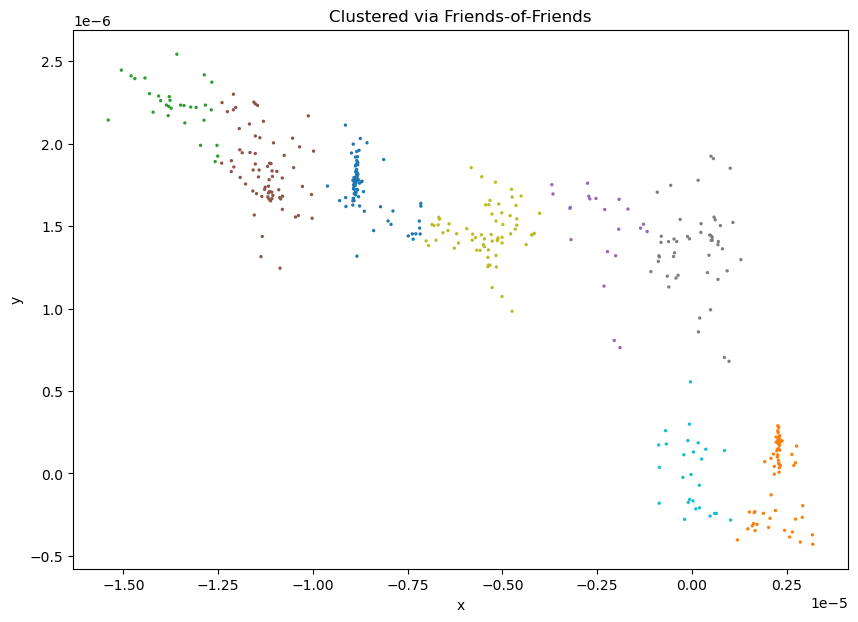

In [33]:
x = data_df['coord1']
y = data_df['coord2']

plt.figure(figsize=(10,7))
plt.scatter(x, y, s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends")
plt.xlabel('x')
plt.ylabel('y')
plt.show()